gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


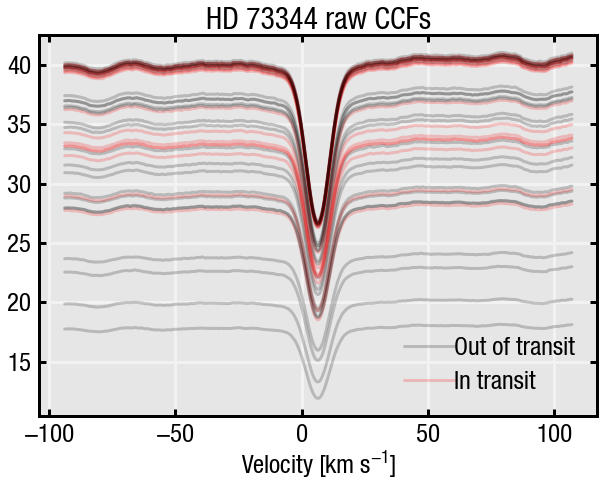

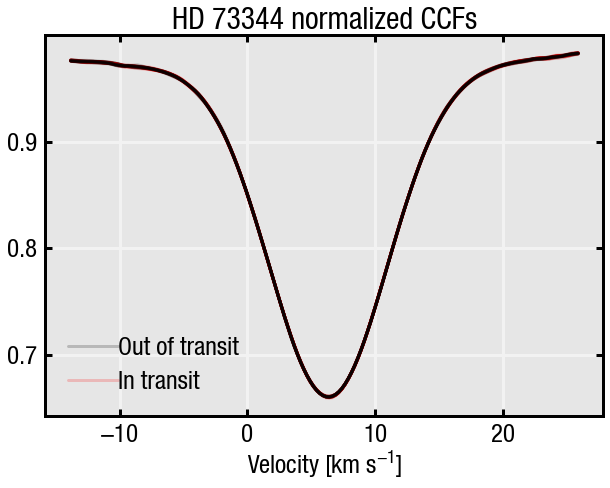

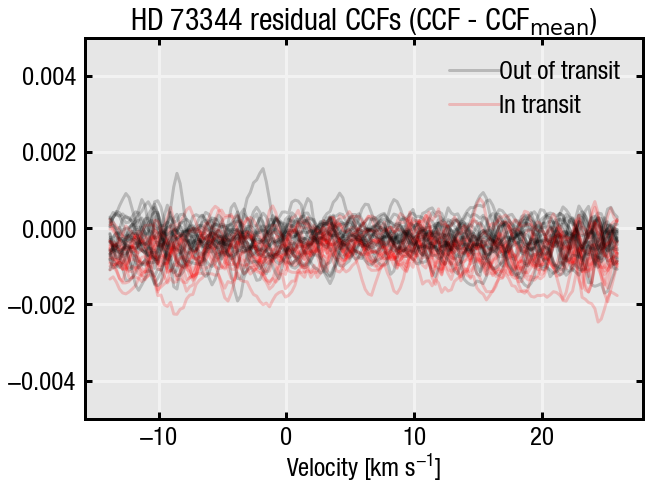

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from astropy.io import fits
import glob
from scipy.signal import savgol_filter

# #---------------------------------------------

# package import and directory handling
#--------------------------------------
import os
from pathlib import Path
import sys

# sort out paths
local_path = Path.home()
file_path = os.path.join(os.path.join(local_path,'Google Drive'),'NEID_DEV')
prv_package_path = os.path.join(file_path,'python_packages_prv')
sys.path.append(prv_package_path) # add path to package search

from PRVccf.libs.fit_gaussian_to_ccf import fit_gaussian_to_ccf
#-----------------------------------------

# plotting preamble
#-----------------------------------------
%matplotlib inline

# sort out paths
local_path = Path.home()
plot_path = os.path.join(os.path.join(local_path,'Google Drive'),'stylelib')
plot_style = os.path.join(plot_path, 'main_grid.mplstyle')
plt.style.use(plot_style)
plt.rcParams['figure.figsize'] = [10,7]
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'  # changes only the mathcal subfamily
#-----------------------------------------

# master wavelength solution file
#-----------------------------------------
wvl_filename = 'neidMaster_HR_Wavelength20200101_v004.fits'
wvl_dir = os.path.join(file_path,'master_wavelength_files')
wvl_file = os.path.join(wvl_dir, wvl_filename)
wvl = fits.getdata(wvl_file, 'CALWAVE') / 10. # nm
Col = plt.get_cmap('Spectral')
#-----------------------------------------

# known bad column indecies (begin, end)
#-----------------------------------------
BAD_COL_INDS = [(434,451),(1930,1945)]
BAD_COL_VAL = np.nan
#-----------------------------------------

# file list of all L2 spectra for given night
#----------------------------------------------------------------
target_name = 'HD 73344'
night = '20210221'
spec_path = os.path.join(os.path.join(os.path.join(os.path.join(file_path,'NEIDdata'),'science_data'),'hd73344'), night)

# spectral SNR cut
snr_cutoff = 90.
#----------------------------------------------------------------

# full night's file list
#----------------------------------------------------------------
fits_files = os.path.join(spec_path,'*.fits')
spec_fits_files = [i for i in glob.glob(fits_files)]

# filter for fits files that are of specific target
files_target = []
jd_arr = []

# loop through each file in night, find which are of specified object
for spc_file in spec_fits_files:
    obj_name = fits.getheader(spc_file)['OBJECT']
    if obj_name == target_name:

        # flux check
        sci_var = fits.getdata(spc_file, 'SCIVAR')
        sci_flux = fits.getdata(spc_file, 'SCIFLUX')
        spec_snr = sci_flux / (sci_var ** 0.5)
        
        # use only files that have CCF fluxes above specified cutoff
        if np.median(np.nanpercentile(spec_snr, 95) > snr_cutoff):
            files_target.append(spc_file)

            # timestamp array
            jd_arr.append(fits.getheader(spc_file)['OBSJD'])

            # get systemic velocity offset (single value per target)
            qrv_offset = (fits.getheader(spc_file)['QRV'])
        # print(obj_name)
#----------------------------------------------------------------

# transit properties -- hopefully these are correct?
#-------------------------------------------------------------------
tdur = 0.1256 # days
tdep = 362e-6 # transit depth
t0 = 2458907.682137
per = 15.6113276
norb = 23.

tcen = t0 + per * norb # BJD
tbeg = tcen - tdur/2. # ingress
tend = tcen + tdur/2. # egress

# frames during transit
inds_transit = np.where((np.asarray(jd_arr) >= tbeg) & (np.asarray(jd_arr) <= tend))

# frames out of transit
inds_outoftransit = np.where((np.asarray(jd_arr) < tbeg) | (np.asarray(jd_arr) > tend))

# CCF scaling factor -- try a dummy step function (no limb darkening)
ccf_scale_fac_transit = np.ones_like(jd_arr)
ccf_scale_fac_transit[inds_transit] = 1. - tdep
#--------------------------------------------------------------------

# load CCF weights (currently stored as python file)
#----------------------------------------------------------------
# load python file with relative CCF weights, or construct the weights based on single exposure
ccf_weights = np.load('hd44420_ccf_weights.npy')

# normalize weights
ccf_weights /= np.nansum(ccf_weights)
#weight_mask = np.zeros_like(ccf_weights)
#weight_mask[55:80] = 1.
#ccf_weights *= weight_mask
#----------------------------------------------------------------

# sort files by jd
sort_inds = np.argsort(jd_arr)
files_target = np.asarray(files_target)[sort_inds]
jd_arr = np.asarray(jd_arr)[sort_inds]

# reconstruct CCF velocity array
vel_start = fits.getheader(files_target[0],'CCFS')['CCFSTART']
vel_step = fits.getheader(files_target[0],'CCFS')['CCFSTEP']
nvels = fits.getheader(files_target[0],'CCFS')['NAXIS1']
vel_arr = np.arange(vel_start + float(qrv_offset), vel_start + nvels * vel_step + float(qrv_offset), vel_step)

# narrow down to velocities in specified window
vel_span = 20. # km/s
vel_window = [-vel_span + float(qrv_offset),vel_span + float(qrv_offset)] # add relevant systemic offset
inds_vel = np.where((vel_arr > min(vel_window)) & (vel_arr < max(vel_window)))

# for each file, load summed CCF and store
summed_ccfs_weighted = []
ccf_all_orders = []
rv_file = []
rv_weighted_arr = []
max_ccf_arr = []
snr_max = []
for ind_fits, targ_fits in enumerate(files_target):

  
    # read in order-by-order CCFs
    ccfs = fits.getdata(targ_fits, 'CCFS')

    # clone for use later when adding relative weights
    ccfs_scaled = ccfs.copy()

    # proxy for overall stellar flux level
    max_ccf_arr.append(np.nanmax(ccfs))

    # stash as-calculated RV from header
    rv_file.append(fits.getheader(targ_fits, 'CCFS')['CCFRVSUM'])

    # Loop through each echelle order, normalize each CCF, and reweight according to ccf_weights
    # ---------------------------------------------------------------------
    nords = ccfs.shape[0]
    ord_arr = []
    ccf_max_ords = []

    for ind, ord_n in enumerate(range(nords)):
        ccf_max_ords.append(np.nanmax(ccfs[ind, :]))

        # reweight order-by-order CCFs
        ccf_sum = np.nansum(ccfs[ind, :])
        ccfs_scaled[ind,:] = (ccfs[ind,:] / ccf_sum) * (ccf_weights[ind])
        if np.nanmedian(ccfs[ind, :] > 0.):
            ord_arr.append(ord_n)
    # ---------------------------------------------------------------------

    # load stellar spectrum and convert back to real units (e-) based on variance
    # --------------------------------------------------------------------
    sci_var = fits.getdata(targ_fits, 'SCIVAR')
    sci_flux = fits.getdata(targ_fits, 'SCIFLUX')
    spec_snr = sci_flux / (sci_var ** 0.5)
    snr_max.append(np.nanpercentile(spec_snr, 95))
    spec_flux = spec_snr ** 2.

    # nuke known bad columns
    for n in range(len(BAD_COL_INDS)):
        spec_flux[:,BAD_COL_INDS[n][0]:BAD_COL_INDS[n][1]] = BAD_COL_VAL

    # # plot full spectrum to check for anything particularly bad
    # if ind_fits == 0.:
    #     plt.rcParams['figure.figsize'] = [35, 6]
    #     for ind, ord_n in enumerate(range(nords)):
    #         wvl_norm = 1. - (np.mean(wvl[ind,:]) - 420.) / (720. - 420.)
    #         spec = spec_flux[ind,:]
    #         plt.plot(wvl[ind,:], spec,c='black',linewidth=3.5)
    #         plt.plot(wvl[ind,:], spec,c=Col(wvl_norm),lw=1.)
    #     plt.title(obj_name)
    #     plt.xlabel('Wavelength [nm]')
    #     plt.ylabel('Recorded flux [counts]')
    #     plt.xlim(380,950)
    #     # plt.xlim(550,650)
    #     plt.show()
    #     plt.rcParams['figure.figsize'] = [10,7]
    # # ---------------------------------------------------------------------

    # sum weighted CCFs for all orders
    ccf_all_weighted = np.nansum(ccfs_scaled, axis=0)

    summed_ccfs_weighted.append(ccf_all_weighted/np.nanmax(ccf_all_weighted))
    
    # store matrix of order CCFs
    ccf_all_orders.append(ccfs)

    # fit gaussian to weighted CCF
    gaussian_fit, g_x, g_y, rv_weighted = fit_gaussian_to_ccf(vel_arr, ccf_all_weighted, 0., velocity_halfrange_to_fit=10.)
    rv_weighted_arr.append(rv_weighted)

    # plot raw CCFs
    if ind_fits in np.asarray(inds_transit):
        if ind_fits == np.asarray(inds_transit).squeeze()[0]:
            label1 = 'In transit'
        else:
            label1 = None
        plt.plot(vel_arr, np.nansum(ccfs, axis=0), 'r', linewidth=3,alpha=0.2, label=label1)
    else: 
        if ind_fits == 0:
            label2 = 'Out of transit'
        else:
            label2 = None
        plt.plot(vel_arr, np.nansum(ccfs, axis=0), 'k', linewidth=3,alpha=0.2, label=label2)

plt.legend(loc='best')
plt.title(target_name + ' raw CCFs')
plt.xlabel('Velocity [km s$^\mathcal{-1}$]')
plt.show()

summed_ccfs_weighted = np.asarray(summed_ccfs_weighted)
ccf_all_orders = np.asarray(ccf_all_orders)

# compute averaged CCF for all out-of-transit frames
avg_ccf_weighted = np.nansum(summed_ccfs_weighted[inds_outoftransit], axis=0)
avg_ccf_weighted /= np.nanmax(avg_ccf_weighted)
avg_ccf_weighted = np.asarray(avg_ccf_weighted)

# plot normalized CCFs
for ind in range(len(files_target)):
    ccf_frame = summed_ccfs_weighted[ind, :]
    if ind in np.asarray(inds_transit):
        if ind == np.asarray(inds_transit).squeeze()[0]:
            label1 = 'In transit'
        else:
            label1 = None
        plt.plot(vel_arr[inds_vel], ccf_frame[inds_vel], 'r', linewidth=3,alpha=0.2, label=label1)
    else: 
        if ind == 0:
            label2 = 'Out of transit'
        else:
            label2 = None
        plt.plot(vel_arr[inds_vel], ccf_frame[inds_vel], 'k', linewidth=3,alpha=0.2, label=label2)

plt.legend(loc='best')
plt.title(target_name + ' normalized CCFs')
plt.xlabel('Velocity [km s$^\mathcal{-1}$]')
plt.show()

# calculate residual CCFs for all orders, and individual orders
# --------------------------------------------------
ccf_diff_weighted = []
ccf_diff_all_ord = []
sigma_resid = []

# for each file, compute residual CCFs relative to average
for ind in range(len(files_target)):

    # weighted
    # diff_ccf_weighted = savgol_filter(summed_ccfs_weighted[ind, :] * ccf_scale_fac_transit[ind] - avg_ccf_weighted, 21, 3)
    diff_ccf_weighted = (summed_ccfs_weighted[ind, :] * ccf_scale_fac_transit[ind] - avg_ccf_weighted)
    ccf_diff_weighted.append(diff_ccf_weighted[inds_vel])

    # order by order residual CCFs
    ccf_diff_ord = []
    for ii, ord_n in enumerate(range(nords)):
        ccf_diff_ord.append(np.squeeze(ccf_all_orders[ind, ii, :]) - avg_ccf_weighted)
    ccf_diff_all_ord.append(ccf_diff_ord)

    # some rudimentary statistics
    sigma_ccf_diff = np.std(diff_ccf_weighted[inds_vel])
    sigma_resid.append(sigma_ccf_diff)

    # plot residual CCFs
    if ind in np.asarray(inds_transit):
        if ind == np.asarray(inds_transit).squeeze()[0]:
            label1 = 'In transit'
        else:
            label1 = None
        plt.plot(vel_arr[inds_vel], diff_ccf_weighted[inds_vel], 'r', linewidth=3,alpha=0.2, label=label1)
    else: 
        if ind == 0:
            label2 = 'Out of transit'
        else:
            label2 = None
        plt.plot(vel_arr[inds_vel], diff_ccf_weighted[inds_vel], 'k', linewidth=3,alpha=0.2, label=label2)

# order by order
ccf_diff_all_ord = np.asarray(ccf_diff_all_ord)
plt.legend(loc='best')
plt.title(target_name + ' residual CCFs (CCF - CCF$_\mathrm{mean}$)')
plt.xlabel('Velocity [km s$^\mathcal{-1}$]')
plt.ylim(-0.005,0.005)
plt.show()
# --------------------------------------------------


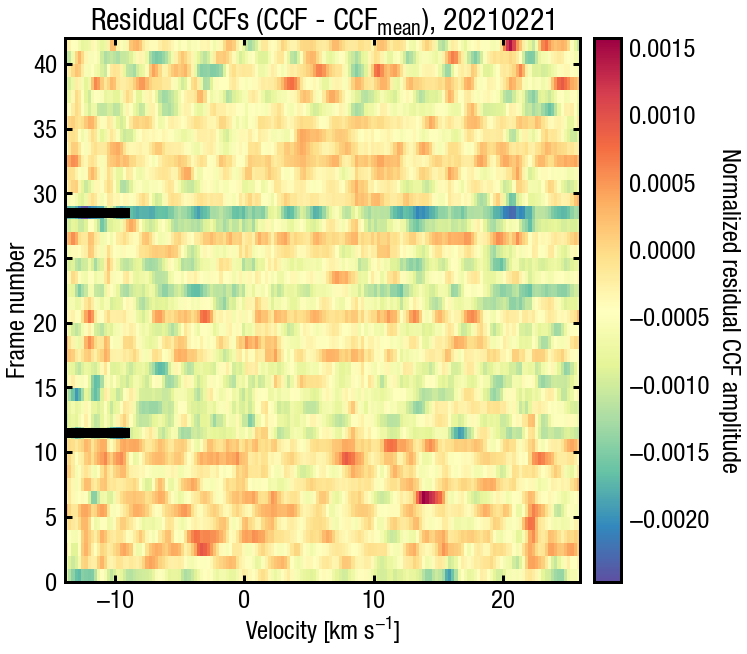

In [2]:
# plot heatmap of CCF residuals over time
plot_style = os.path.join(plot_path, 'main_grid.mplstyle')
plt.style.use(plot_style)
plt.rcParams['figure.figsize'] = [25,10]
plt.rcParams['grid.linewidth'] = 0

import matplotlib.pyplot as plt

ccf_diff_weighted = np.asarray(ccf_diff_weighted)

cmap = plt.cm.Spectral.reversed()
im = plt.imshow(np.flip(ccf_diff_weighted), interpolation='None', extent=[min(vel_arr[inds_vel]), max(vel_arr[inds_vel]), 0, len(files_target)],
                cmap=cmap, aspect=1)

plt.xlabel('Velocity [km s$^\mathcal{-1}$]')
plt.ylabel('Frame number')
plt.title('Residual CCFs (CCF - CCF$_\mathcal{mean}$), ' + night)

cbar = plt.colorbar(im,fraction=0.046, pad=0.01)
cbar.set_label('Normalized residual CCF amplitude', rotation=-90, labelpad=30)

# label beginning, end of transit window
plt.hlines([np.min(inds_transit) + 0.5, np.max(inds_transit) + 0.5],min(vel_arr[inds_vel]),min(vel_arr[inds_vel]) + 5,'k', linewidth=10)
plt.show()
plt.rcParams['grid.linewidth'] = 3

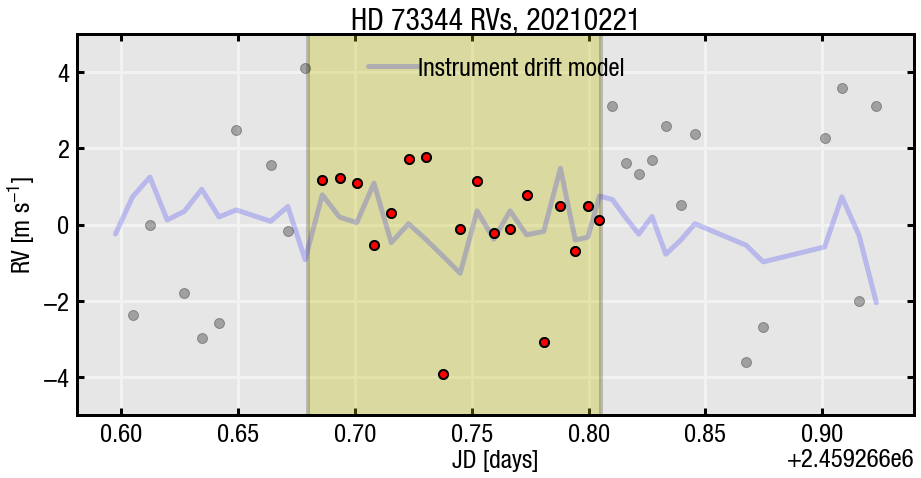

In [36]:
from scipy.interpolate import interp1d

# load precomputed drift values
#-----------------------------------------
drifts = fits.getdata('Etalon_drifts_20210221_CAL.fits')
drifts_jd = fits.getdata('Etalon_drifts_20210221_CAL_timestamps.fits')
#-----------------------------------------

# interpolate calfiber drift onto sci-fiber time stamps
drift_interp = interp1d(drifts_jd, drifts, kind='linear',fill_value="extrapolate")
drift_vals = drift_interp(jd_arr)
drift_corrected_rvs = np.asarray(np.asarray(rv_weighted_arr) * 1e3 - drift_vals)
drift_corrected_rvs -= np.mean(drift_corrected_rvs)

# plot RVs
plot_style = os.path.join(plot_path, 'main_grid.mplstyle')
plt.style.use(plot_style)
plt.rcParams['figure.figsize'] = [15,7]

plt.plot(jd_arr, drift_vals,'-b', alpha=0.2,linewidth=5, label='Instrument drift model')

plt.plot(jd_arr, (np.asarray(rv_weighted_arr) - np.mean(rv_weighted_arr))*1e3,'ko', markersize=10, alpha=0.3)

plt.plot(jd_arr[inds_transit], (np.asarray(rv_weighted_arr)[inds_transit] - np.mean(rv_weighted_arr))*1e3,'ko', markersize=10)
plt.plot(jd_arr[inds_transit], (np.asarray(rv_weighted_arr)[inds_transit] - np.mean(rv_weighted_arr))*1e3,'ro', markersize=6)

# plt.plot(jd_arr, drift_corrected_rvs,'ko', markersize=10, alpha=0.3)

# plt.plot(jd_arr[inds_transit], drift_corrected_rvs[inds_transit],'ko', markersize=10)
# plt.plot(jd_arr[inds_transit],  drift_corrected_rvs[inds_transit],'ro', markersize=6)


# plt.plot(jd_arr, drift_corrected_rvs,'ro', markersize=6)

plt.title(obj_name + ' RVs, ' + night)
plt.xlabel('JD [days]')
plt.ylabel('RV [m s$^\mathcal{-1}$]')
plt.ylim(-5,5)
plt.legend(loc='best')

# highlight transit window
plt.axvspan(tbeg,tend, color='y', alpha=0.3, lw=0)
plt.vlines([tbeg,tend],-10, 10, alpha=0.2, linewidth=4)

plt.show()

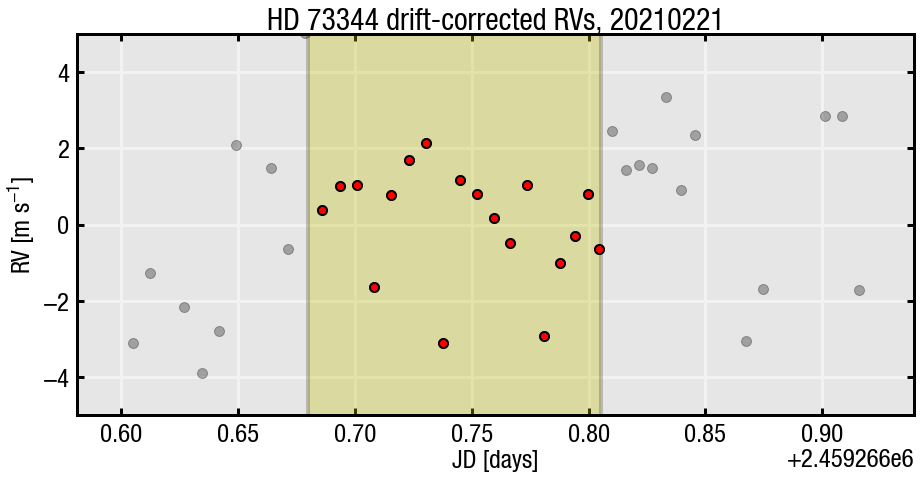

In [42]:
plt.plot(jd_arr, drift_corrected_rvs,'ko', markersize=10, alpha=0.3)

plt.plot(jd_arr[inds_transit], drift_corrected_rvs[inds_transit],'ko', markersize=10)
plt.plot(jd_arr[inds_transit],  drift_corrected_rvs[inds_transit],'ro', markersize=6)

plt.title(obj_name + ' drift-corrected RVs, ' + night)
plt.xlabel('JD [days]')
plt.ylabel('RV [m s$^\mathcal{-1}$]')
plt.ylim(-5,5)

# highlight transit window
plt.axvspan(tbeg,tend, color='y', alpha=0.3, lw=0)
plt.vlines([tbeg,tend],-10, 10, alpha=0.2, linewidth=4)

plt.show()

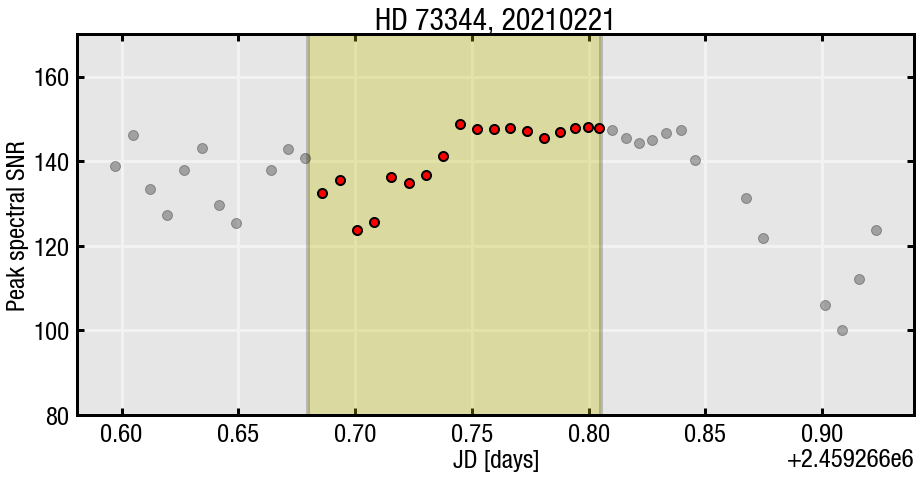

In [4]:

# plot relative flux ratio over time
plot_style = os.path.join(plot_path, 'main_grid.mplstyle')
plt.style.use(plot_style)
plt.rcParams['figure.figsize'] = [15,7]

plt.plot(jd_arr[inds_outoftransit], np.asarray(snr_max)[inds_outoftransit],'ko',markersize=10,alpha=0.3)

plt.plot(jd_arr[inds_transit], np.asarray(snr_max)[inds_transit],'ko',markersize=10)
plt.plot(jd_arr[inds_transit], np.asarray(snr_max)[inds_transit],'ro',markersize=6)
plt.title(obj_name + ', ' + night)
plt.xlabel('JD [days]')
plt.ylabel('Peak spectral SNR')

# highlight transit window
plt.axvspan(tbeg,tend, color='y', alpha=0.3, lw=0)
plt.vlines([tbeg,tend],80,170, alpha=0.2, linewidth=4)
plt.ylim(80,170)

plt.show()